In [1]:
import pdfplumber
import fitz  # PyMuPDF
import base64
from IPython.display import display, Image as IPImage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os 
from dotenv import load_dotenv
import nest_asyncio
from pathlib import Path
from openai import OpenAI
import contextlib
from langchain.chains.summarize import load_summarize_chain
from langchain_core.documents import Document
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter
import fitz  # PyMuPDF
from docx import Document


current_directory = os.getcwd()
print("Current Directory:", current_directory)  # พิมพ์ที่อยู่ปัจจุบัน

# ปรับเส้นทางไปยังไฟล์ .env ในโฟลเดอร์ venv
env_path = Path(current_directory).parent.parent / 'venv' / '.env'
print("Env Path:", env_path)  # พิมพ์เส้นทางที่ไปยัง .env

load_dotenv(dotenv_path=env_path)


nest_asyncio.apply()

Current Directory: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\test\OCR
Env Path: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\venv\.env


In [16]:
# keys for the services we will use
OPENAI_API_KEY : str 
GROQ_API_KEY : str
LANGCHAIN_API_KEY : str
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')

In [17]:
# ---------- อ่าน PDF: ข้อความ + ตาราง ----------
text_content = ""
tables_content = []
images_b64 = []
file_path_pdf = './test_data/NIPS-2017-attention-is-all-you-need-Paper.pdf'
with pdfplumber.open(file_path_pdf) as pdf:
    for page_num, page in enumerate(pdf.pages, start=1):
        try:
            text = page.extract_text()
            if text:
                text_content += f"\n--- Page {page_num} ---\n{text}"
            
            tables = page.extract_tables()
            if tables:
                for table in tables:
                    if table:
                        tables_content.append(table)

        except Exception as e:
            print(f"❌ Error processing page {page_num}: {e}")

logging.getLogger("pdfminer").setLevel(logging.ERROR)

In [32]:
# --------- ดึงรูปภาพจาก PyMuPDF ---------
# เปิดไฟล์ PDF
doc = fitz.open(file_path_pdf)

# สร้าง list สำหรับเก็บ base64 ของรูปภาพ
images_b64 = []

# ลูปผ่านแต่ละหน้าใน PDF
for page_index in range(len(doc)):
    page = doc.load_page(page_index)  # โหลดหน้าปัจจุบัน
    images = page.get_images(full=True)  # ดึงข้อมูลรูปภาพทั้งหมดในหน้านั้น
    
    for img_index, img in enumerate(images):
        xref = img[0]  # ดึง xref ของรูปภาพ
        base_image = doc.extract_image(xref)  # Extract รูปภาพ
        image_bytes = base_image["image"]  # ข้อมูลรูปภาพ
        image_b64 = base64.b64encode(image_bytes).decode("utf-8")  # แปลงเป็น base64
        images_b64.append(image_b64)  # เก็บไว้ใน list

print(f"พบรูปภาพจำนวน: {len(images_b64)}")


พบรูปภาพจำนวน: 3


In [19]:

print(f"📄 ข้อความจาก DOCX: {len(text_content)} อักขระ")
print(f"📊 จำนวนตารางที่ดึงได้จาก DOCX: {len(tables_content)}")
print(f"🖼️ จำนวนรูปภาพที่ดึงได้จาก DOCX: {len(images_b64)}")

📄 ข้อความจาก DOCX: 29422 อักขระ
📊 จำนวนตารางที่ดึงได้จาก DOCX: 1
🖼️ จำนวนรูปภาพที่ดึงได้จาก DOCX: 3


In [35]:
file_path_docx = '../data_docx/Fundamentals-Machine-Learning-Analyzing-Data-with-Python.docx'
doc = Document(file_path_docx)

text_docx = ""
tables_content_docx = []
images_b64_doc = []

# ---------- อ่านข้อความจาก paragraph ----------
for para in doc.paragraphs:
    text_docx += para.text + "\n"

# ---------- อ่านตาราง ----------
for table_idx, table in enumerate(doc.tables):
    table_data = []
    for row in table.rows:
        row_data = [cell.text.strip() for cell in row.cells]
        table_data.append(row_data)
    tables_content_docx.append(table_data)

# ---------- อ่านรูปภาพจาก inline_shapes ----------
for i, shape in enumerate(doc.inline_shapes):
    try:
        # ดึงข้อมูลภาพจากไฟล์ .docx
        image = shape._inline.graphic.graphicData.pic.blipFill.blip.embed
        image_part = doc.part.related_parts[image]
        image_bytes = image_part.blob

        # แปลงรูปภาพเป็น base64
        image_b64 = base64.b64encode(image_bytes).decode("utf-8")
        
        # เก็บ base64 ของรูปภาพใน list
        images_b64_doc.append(image_b64)

    except Exception as e:
        print(f"❌ Error extracting DOCX image {i+1}: {e}")

# ตรวจสอบจำนวนภาพที่ได้
print(f"✅ พบรูปภาพทั้งหมด {len(images_b64_doc)} รูปภาพใน DOCX")

# ---------- สรุปผล ----------
text_content += f"\n--- DOCX Content ---\n{text_docx}"
print(f"📄 ข้อความจาก DOCX: {len(text_docx)} อักขระ")
print(f"📊 จำนวนตารางที่ดึงได้จาก DOCX: {len(tables_content_docx)}")
print(f"🖼️ จำนวนรูปภาพที่ดึงได้จาก DOCX: {len(images_b64_doc)}")

✅ พบรูปภาพทั้งหมด 21 รูปภาพใน DOCX
📄 ข้อความจาก DOCX: 103593 อักขระ
📊 จำนวนตารางที่ดึงได้จาก DOCX: 14
🖼️ จำนวนรูปภาพที่ดึงได้จาก DOCX: 21


In [21]:
# --------- การแสดงผลภาพ ---------
def display_base64_image(base64_code):
    image_data = base64.b64decode(base64_code)
    display(IPImage(data=image_data))

# change index look another image
# display_base64_image(images_b64[1])    

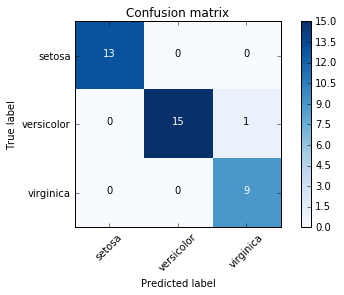

In [11]:
display_base64_image(images_b64_doc[11]) #docx

In [12]:
client = OpenAI(api_key=OPENAI_API_KEY)

image_b64 = images_b64[2]

prompt = """
กรุณาวิเคราะห์และอธิบายภาพด้านล่างอย่างละเอียด โดยเน้นการนำเสนอในเชิงวิชาการ เพื่อให้เหมาะสมสำหรับการนำไปใช้ในเอกสารวิจัยหรือเอกสารวิชาการทั่วไป

ข้อกำหนดการอธิบาย:
1. วิเคราะห์องค์ประกอบที่ปรากฏในภาพอย่างละเอียด ทั้งในเชิงโครงสร้าง เนื้อหา และความสัมพันธ์ของข้อมูล
2. หากภาพนั้นเป็นกราฟหรือแผนภูมิ ให้ระบุข้อมูลที่ปรากฏบนแกน X และแกน Y อย่างชัดเจน แต่หากไม่มีแกนดังกล่าว สามารถข้ามข้อนี้ได้
3. อธิบายลำดับความสัมพันธ์ของข้อมูลหรือองค์ประกอบต่าง ๆ โดยนำเสนอในรูปแบบลำดับขั้นตอน (Step-by-step) เริ่มจากองค์ประกอบหลักก่อน แล้วจึงอธิบายองค์ประกอบรองตามลำดับ
4. ต้องเขียนด้วยข้อความธรรมดาเท่านั้น ห้ามใช้รูปแบบ Markdown เช่น การทำตัวหนา ตัวเอียง หรือการเน้นข้อความด้วยสัญลักษณ์พิเศษ เช่น ** ## * _
5. เนื้อหาต้องจัดเรียงให้อ่านง่าย ชัดเจน เป็นระบบ และมีความต่อเนื่องของตรรกะ
6. ใช้ภาษาทางวิชาการที่สุภาพ ถูกต้อง และสมบูรณ์ เหมาะสมสำหรับการนำไปใช้อ้างอิงในงานวิจัยหรือเอกสารวิชาการในทุกสาขา

หมายเหตุ: คำอธิบายควรมีความละเอียด ครอบคลุม และคำนึงถึงความสมบูรณ์ของเนื้อหาเป็นสำคัญ
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_b64}"
                    }
                }
            ]
        }
    ],
    temperature=0
)

# แสดงผลลัพธ์
print(response.choices[0].message.content)

ภาพที่นำเสนอเป็นแผนภาพที่แสดงถึงกระบวนการทำงานของโมเดลการเรียนรู้เชิงลึก โดยเฉพาะในบริบทของการประมวลผลข้อมูลที่เกี่ยวข้องกับการทำ Attention Mechanism ซึ่งเป็นส่วนสำคัญในโมเดล Transformer ที่ใช้ในงานด้านการประมวลผลภาษาธรรมชาติ (Natural Language Processing) และการเรียนรู้เชิงลึกอื่น ๆ

1. องค์ประกอบหลักในภาพ
   - องค์ประกอบหลักในภาพประกอบด้วยกล่องที่มีชื่อว่า "MatMul" สองกล่อง ซึ่งแสดงถึงการคูณเมทริกซ์ (Matrix Multiplication) ที่เกิดขึ้นในกระบวนการ
   - กล่อง "SoftMax" ซึ่งทำหน้าที่ในการปรับค่าความน่าจะเป็นให้รวมกันเป็นหนึ่ง
   - กล่อง "Mask (opt.)" ซึ่งเป็นตัวเลือกในการปิดกั้นข้อมูลบางส่วนเพื่อป้องกันการรั่วไหลของข้อมูลในระหว่างการฝึก
   - กล่อง "Scale" ที่ใช้ในการปรับขนาดค่าที่ได้จากการคูณเมทริกซ์

2. องค์ประกอบรอง
   - องค์ประกอบรองในภาพ ได้แก่ Q, K, และ V ซึ่งเป็นตัวแทนของ Query, Key, และ Value ตามลำดับ ซึ่งเป็นข้อมูลที่ใช้ในการคำนวณ Attention
   - การเชื่อมโยงระหว่าง Q, K, และ V กับกล่อง MatMul แสดงถึงการคูณเมทริกซ์ระหว่างข้อมูลเหล่านี้เพื่อคำนวณค่าความสนใจ

3. ลำดับความสัมพันธ์ของข

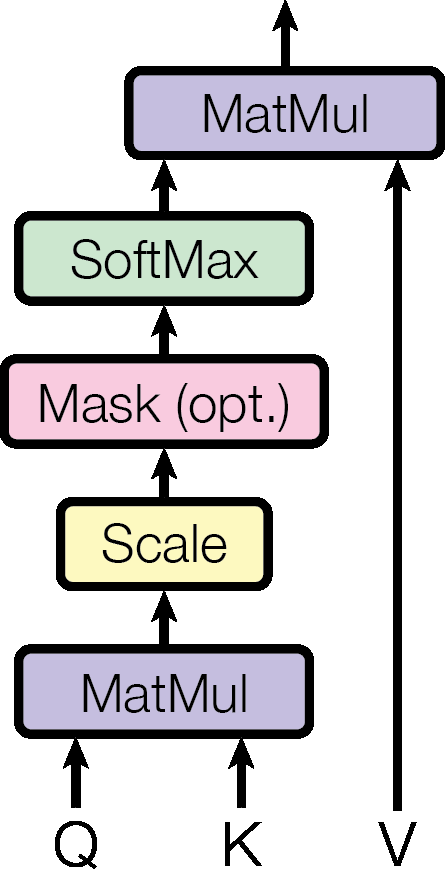

In [10]:
display_base64_image(images_b64[2])

Read text

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
summarize_chain = load_summarize_chain(llm, chain_type="stuff")
text_documents = [Document(page_content=text_content)]


In [13]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200,  # ให้มีบริบทซ้อนเล็กน้อย
)

In [14]:
documents = text_splitter.create_documents([text_content])


In [15]:
# สรุปแต่ละ chunk ทีละตัว
text_summaries = []
for i, doc in enumerate(documents):
    print(f"🔍 Summarizing chunk {i+1}/{len(documents)}...")
    summary = summarize_chain.invoke({"input_documents": [doc]})
    text_summaries.append(summary["output_text"])

🔍 Summarizing chunk 1/17...
🔍 Summarizing chunk 2/17...
🔍 Summarizing chunk 3/17...
🔍 Summarizing chunk 4/17...
🔍 Summarizing chunk 5/17...
🔍 Summarizing chunk 6/17...
🔍 Summarizing chunk 7/17...
🔍 Summarizing chunk 8/17...
🔍 Summarizing chunk 9/17...
🔍 Summarizing chunk 10/17...
🔍 Summarizing chunk 11/17...
🔍 Summarizing chunk 12/17...
🔍 Summarizing chunk 13/17...
🔍 Summarizing chunk 14/17...
🔍 Summarizing chunk 15/17...
🔍 Summarizing chunk 16/17...
🔍 Summarizing chunk 17/17...


In [16]:
# รวมทั้งหมดเป็นข้อความเดียว
full_summary = "\n\n".join(text_summaries)

In [17]:
# แสดงผล
print("\n✅ Full Summary:\n", full_summary)


✅ Full Summary:
 Google Brain researchers propose a new network architecture called the Transformer, which is based solely on attention mechanisms and does not include recurrent or convolutional neural networks. Experiments on two machine translation tasks show these models to be superior in quality, more parallelizable, and require less time to train. The model achieved a new single-model state-of-the-art BLEU score of 41.0 after training for 3.5 days on eight GPUs, improving over the existing best results.

Ashish and Illia designed and implemented the first Transformer models, with Noam proposing key features such as scaled dot-product attention, multi-head attention, and the parameter-free position representation. Niki and Llion were responsible for designing, implementing, and evaluating numerous model variants, while Lukasz and Aidan worked on developing the tensor2tensor codebase. The work was performed at Google Brain and Google Research. The Transformer model is a new archite

Read Table

In [21]:
# แปลงตารางเป็นข้อความ
table_texts = []
for table in tables_content:
    # แปลงแต่ละแถวของตารางเป็นข้อความ
    table_text = "\n".join(["\t".join(row) for row in table if row])  # ใช้ tab คั่นระหว่างคอลัมน์
    table_texts.append(table_text)


In [24]:
# สร้าง Document สำหรับตาราง
table_documents = [Document(page_content=table_text) for table_text in table_texts]

In [25]:
# สรุปตาราง
print("🔍 Summarizing tables...")
table_summaries = []
for doc in table_documents:
    summary = summarize_chain.invoke({"input_documents": [doc]})
    table_summaries.append(summary["output_text"])


🔍 Summarizing tables...


In [27]:
# รวมผลสรุป
full_table_summary = "\n\n".join(table_summaries)

In [28]:
# แสดงผล
print("\n✅ Full Table Summary:\n", full_table_summary)


✅ Full Table Summary:
 The text appears to be a list of parameters or settings for a machine learning model or algorithm, possibly related to neural networks or deep learning. It includes values for model layers, dimensionalities, dropout rates, learning rates, and training steps. There's also a mention of using positional embedding instead of sinusoids, which suggests a specific approach to handling sequential data.


# EMBEDDING

In [13]:
# Embedding text docx
import asyncio
from openai import AsyncOpenAI
import textwrap

# ตัดข้อความเป็นช่วง ๆ ละ 800 ตัวอักษร (ประมาณ 300-500 token)
client_openai = AsyncOpenAI(api_key=OPENAI_API_KEY)
EMBEDDING = "text-embedding-3-small"

# รวมข้อความจาก docx และตาราง
all_text = text_docx + "\n"
for table in tables_content_docx:
    for row in table:
        all_text += " | ".join(row) + "\n"

# แบ่งข้อความก่อน
split_text = textwrap.wrap(all_text, width=800)

# ฟังก์ชันสำหรับ embed ทีละ batch
async def embed_batch(batch, embed_model):
    response = await client_openai.embeddings.create(model=embed_model, input=batch)
    return [item.embedding for item in response.data]

# ฟังก์ชันจัดการ batch ทั้งหมด
async def batch_process_embedding_async(text_list, embed_model, batch_size=100):
    assert isinstance(text_list, list), "❌ text_list ต้องเป็น list ของข้อความ"
    tasks = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        tasks.append(embed_batch(batch, embed_model))
    results = await asyncio.gather(*tasks)
    embeddings = [embedding for batch in results for embedding in batch]
    return embeddings

# สร้าง embeddings
embeddings = await batch_process_embedding_async(split_text, EMBEDDING)
print(f"✅ สร้าง embedding ข้อความแล้ว: จำนวนเวกเตอร์ = {len(embeddings)}")


✅ สร้าง embedding ข้อความแล้ว: จำนวนเวกเตอร์ = 137


In [25]:
table_embeddings = []

for table in tables_content_docx:
    table_text = "\n".join([" | ".join(row) for row in table])
    split_text = textwrap.wrap(table_text, width=800)  # ✅ ต้องอยู่ในลูป
    embedding_response = await batch_process_embedding_async(split_text, EMBEDDING)
    table_embeddings.extend(embedding_response)

print(f"✅ สร้าง embedding จาก {len(table_embeddings)} ตารางแล้ว")


✅ สร้าง embedding จาก 15 ตารางแล้ว


In [ ]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import base64
from io import BytesIO
from transformers import CLIPModel, CLIPProcessor
import os
# HF_TOKEN = os.getenv("HF_TOKEN") ##เปิดออกถ้าต้องใช้
# เลือกที่จะดาวน์โหลดโมเดลไว้ในเครื่อง
cache_dir = "./my_model_cache"
# โหลดโมเดลจาก cache หากมี หรือดาวน์โหลดใหม่
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_auth_token=HF_TOKEN, cache_dir=cache_dir)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_auth_token=HF_TOKEN, cache_dir=cache_dir)
# ใช้โมเดลและ processor ที่โหลดไว้แล้ว
image_embeddings = []

# loop ผ่านรูปภาพ base64
for img_b64 in images_b64_doc:
    # แปลง base64 เป็น Image
    image = Image.open(BytesIO(base64.b64decode(img_b64))).convert("RGB")
    
    # ประมวลผลรูปภาพ
    inputs = processor(images=image, return_tensors="pt")
    
    # คำนวณ embeddings โดยไม่ต้องอัพเดต gradient
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        
        # บันทึก embeddings
        image_embeddings.append(image_features.squeeze().tolist())

print(f"✅ สร้าง embedding จากรูปภาพจำนวน: {len(image_embeddings)}")

✅ สร้าง embedding จากรูปภาพจำนวน: 21
